In [1]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

import os
path = os.path.dirname(os.getcwd())
path = os.path.dirname(path)
path = os.path.join(path, "Daesamanlap/ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

import warnings
warnings.filterwarnings(action='ignore')

train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [2]:
## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

### 2) 세대당가능주차면수

train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

### 3) 공가비율

train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

### 4) 대형전용면적

level = 85

train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
#- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

#- 1차원으로 합치기

not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

#- 전용면적별세대수 채우기

for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

### 6) 임대료 임대보증금 : 평균

sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 연면적 / 전용면적은 나중에 drop

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2) # 12345 중에 2가 제일 좋음

sample = train.groupby('단지코드').mean()[['전용면적']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

sample = test.groupby('단지코드').mean()[['전용면적']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

train_one["연면적new"]=train_one.연면적
test_one["연면적new"]=test_one.연면적

train_one.loc[(train_one.연면적new<train_one.전용면적), "연면적new"]=np.nan
test_one.loc[(test_one.연면적new<test_one.전용면적), "연면적new"]=np.nan

#train_one.isna().sum() # 63

#test_one.isna().sum() #23

im=train_one[["단지내주차면수", "총세대수", "전용면적", "연면적new"]]
im = pd.DataFrame(imputer.fit_transform(im),
                     columns = im.columns)

train_one["연면적new"]=im["연면적new"]

imp=test_one[["단지내주차면수", "총세대수", "전용면적", "연면적new"]]
imp = pd.DataFrame(imputer.fit_transform(imp),
                     columns = imp.columns)

test_one["연면적new"]=imp["연면적new"]

### 7) 대형전용면적 총개수

sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

### 8) 변수제거

col = ['단지명','도로명주소','subway_name','임대상가', '전용면적']

train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)

In [3]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)
test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

In [4]:
# def areafunc(x):
#     if x in ['제주특별자치도','경상남도','부산광역시']:
#         return 0 
#     elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
#         return 1
#     elif x in ['대구광역시']:
#         return 2
#     else: 
#         return 3
    

In [5]:
# train_up['지역'] = train_up['지역'].apply(lambda x : areafunc(x))
# test_up['지역'] = test_up['지역'].apply(lambda x : areafunc(x))
# train_up = train_up.join(pd.get_dummies(train_up['지역'],prefix='area')).iloc[:,:-1]
# test_up = test_up.join(pd.get_dummies(test_up['지역'],prefix='area')).iloc[:,:-1]

## 모델링

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [7]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

In [8]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)
test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

In [9]:
train_one.단지내주차면수.describe()

count     414.000000
mean      586.330918
std       363.665625
min        13.000000
25%       318.250000
50%       517.000000
75%       785.750000
max      1798.000000
Name: 단지내주차면수, dtype: float64

In [10]:
list(train_one.단지내주차면수.quantile((.25,.75)))

[318.25, 785.75]

In [11]:
train_one.단지내주차면수.sort_values()

392      13.0
411      25.0
262      27.0
412      30.0
295      50.0
        ...  
336    1689.0
363    1713.0
247    1741.0
244    1756.0
345    1798.0
Name: 단지내주차면수, Length: 414, dtype: float64

In [12]:
q1, q3 = list(train_one.단지내주차면수.quantile((.25,.75)))


In [33]:
train_one.단지내주차면수.quantile((.25,.75))

0.25    318.25
0.75    785.75
Name: 단지내주차면수, dtype: float64

In [13]:
print("up",q1)

up 318.25


In [14]:
tmp = train_one.단지내주차면수.sort_values()
tmp = tmp[(tmp>=q1)&(tmp<= q3)]
mae_down = []
mae_up = []
mae_all = []
for t in tmp: 
    print("------------------------")
    print("down",t)
    train_up = train_one[train_one['단지내주차면수']>=t].reset_index(drop=True)
    train_down = train_one[train_one['단지내주차면수']<t].reset_index(drop=True)
    test_up = test_one[test_one['단지내주차면수']>=t].reset_index(drop=True)
    test_down = test_one[test_one['단지내주차면수']<t].reset_index(drop=True)
    
    X = train_down.drop(columns=['단지코드','등록차량수', "연면적new"],axis=1)
    X = pd.get_dummies(X, drop_first=True) 
    y = train_down['등록차량수']
    
    models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
    model_down,pred_down,error_down = fit_models(X, y, models, cv=True)
    print('MAE_dwn : ',error_down)
    mae_down.append(error_down)
    
    print("up",t)
    X = train_up.drop(columns=['단지코드','등록차량수', "연면적new"],axis=1)
    X = pd.get_dummies(X, drop_first=True) 
    y = train_up['등록차량수']
    
    models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
    model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
    print('MAE_up : ',error_up)
    mae_down.append(error_up)
    error = (error_down*len(train_down)+error_up*len(train_up))/(len(train_one))
    print("MAE :",error)
    mae_all.append(error)

------------------------
down 319.0
MAE_dwn :  57.54745735940095
up 319.0
MAE_up :  156.597676242413
MAE : 131.71549565344378
------------------------
down 320.0
MAE_dwn :  60.88853187598198
up 320.0
MAE_up :  152.66573568120822
MAE : 129.3889086291581
------------------------
down 321.0
MAE_dwn :  59.71279326703285
up 321.0
MAE_up :  149.9079605414845
MAE : 126.81451191565873
------------------------
down 325.0
MAE_dwn :  60.74580679667853
up 325.0
MAE_up :  147.92593608987852
MAE : 125.39387368801283
------------------------
down 329.0
MAE_dwn :  58.77910516543587
up 329.0
MAE_up :  155.67722484923982
MAE : 130.39945449694315
------------------------
down 330.0
MAE_dwn :  58.30547048298447
up 330.0
MAE_up :  157.72042218196322
MAE : 131.54595422257026
------------------------
down 330.0
MAE_dwn :  58.30547048298447
up 330.0
MAE_up :  157.72042218196322
MAE : 131.54595422257026
------------------------
down 333.0
MAE_dwn :  60.304254783116086
up 333.0
MAE_up :  152.17911716770774
MAE 

MAE_up :  165.0779585563916
MAE : 127.6093363108293
------------------------
down 428.0
MAE_dwn :  72.35010303493728
up 428.0
MAE_up :  172.74746527912652
MAE : 131.76400098137776
------------------------
down 434.0
MAE_dwn :  70.12685741679715
up 434.0
MAE_up :  179.11031777080584
MAE : 134.3586553065994
------------------------
down 434.0
MAE_dwn :  70.12685741679715
up 434.0
MAE_up :  179.11031777080584
MAE : 134.3586553065994
------------------------
down 436.0
MAE_dwn :  72.65716027958011
up 436.0
MAE_up :  185.09835613477543
MAE : 138.3836564074962
------------------------
down 437.0
MAE_dwn :  72.10436468617462
up 437.0
MAE_up :  173.71448276733207
MAE : 131.25421603293537
------------------------
down 438.0
MAE_dwn :  70.12781046139446
up 438.0
MAE_up :  182.40289895259545
MAE : 135.21481828238055
------------------------
down 438.0
MAE_dwn :  70.12781046139446
up 438.0
MAE_up :  182.40289895259545
MAE : 135.21481828238055
------------------------
down 442.0
MAE_dwn :  71.93029

MAE_dwn :  80.62290382443727
up 573.0
MAE_up :  190.01131168383222
MAE : 128.7115275693887
------------------------
down 574.0
MAE_dwn :  81.0727127209125
up 574.0
MAE_up :  201.78074342284324
MAE : 133.55446520001283
------------------------
down 579.0
MAE_dwn :  82.39757565634382
up 579.0
MAE_up :  204.86608283052237
MAE : 135.3489350384162
------------------------
down 581.0
MAE_dwn :  80.86392674883106
up 581.0
MAE_up :  204.334226167785
MAE : 133.95019075021705
------------------------
down 582.0
MAE_dwn :  80.63597447372999
up 582.0
MAE_up :  196.90906911167826
MAE : 130.34693522473685
------------------------
down 583.0
MAE_dwn :  80.94805163964261
up 583.0
MAE_up :  190.3599875136389
MAE : 127.46133838800819
------------------------
down 584.0
MAE_dwn :  79.3583781093877
up 584.0
MAE_up :  191.09242583569554
MAE : 126.5889538391072
------------------------
down 592.0
MAE_dwn :  79.95167221866578
up 592.0
MAE_up :  199.05452389322295
MAE : 130.00939248768256
--------------------

MAE_dwn :  93.61182052463649
up 759.0
MAE_up :  225.79226882872476
MAE : 130.64788816539553
------------------------
down 761.0
MAE_dwn :  92.45353800001712
up 761.0
MAE_up :  224.47603128568062
MAE : 129.12645280159032
------------------------
down 763.0
MAE_dwn :  95.17604824016038
up 763.0
MAE_up :  222.5800474698386
MAE : 130.258308897608
------------------------
down 770.0
MAE_dwn :  94.82411743496868
up 770.0
MAE_up :  225.7466839320894
MAE : 130.55902085084946
------------------------
down 771.0
MAE_dwn :  92.76690673966343
up 771.0
MAE_up :  228.06051884443363
MAE : 129.3680771641423
------------------------
down 772.0
MAE_dwn :  90.69898613260975
up 772.0
MAE_up :  233.7446910381785
MAE : 129.05182005656658
------------------------
down 772.0
MAE_dwn :  90.69898613260975
up 772.0
MAE_up :  233.7446910381785
MAE : 129.05182005656658
------------------------
down 772.0
MAE_dwn :  90.69898613260975
up 772.0
MAE_up :  233.7446910381785
MAE : 129.05182005656658
--------------------

In [20]:
np.min(mae_all), np.argmin(mae_all)

(124.91324723553214, 180)

In [23]:
list(tmp)[180]

719.0

<AxesSubplot:xlabel='단지내주차면수'>

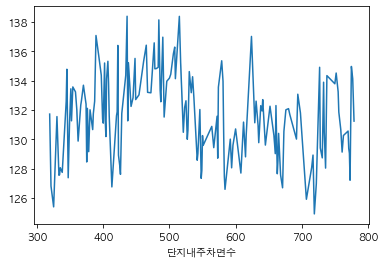

In [17]:
sns.lineplot(x = tmp, y = mae_all)

In [24]:
tmp = train_one.단지내주차면수.sort_values()
tmp = tmp[(tmp>= q3)]
# mae_down = []
# mae_up = []
# mae_all = []
for t in tmp: 
    print("------------------------")
    print("down",t)
    train_up = train_one[train_one['단지내주차면수']>=t].reset_index(drop=True)
    train_down = train_one[train_one['단지내주차면수']<t].reset_index(drop=True)
    test_up = test_one[test_one['단지내주차면수']>=t].reset_index(drop=True)
    test_down = test_one[test_one['단지내주차면수']<t].reset_index(drop=True)
    
    X = train_down.drop(columns=['단지코드','등록차량수', "연면적new"],axis=1)
    X = pd.get_dummies(X, drop_first=True) 
    y = train_down['등록차량수']
    
    models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
    model_down,pred_down,error_down = fit_models(X, y, models, cv=True)
    print('MAE_dwn : ',error_down)
    mae_down.append(error_down)
    
    print("up",t)
    X = train_up.drop(columns=['단지코드','등록차량수', "연면적new"],axis=1)
    X = pd.get_dummies(X, drop_first=True) 
    y = train_up['등록차량수']
    
    models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
    model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
    print('MAE_up : ',error_up)
    mae_down.append(error_up)
    error = (error_down*len(train_down)+error_up*len(train_up))/(len(train_one))
    print("MAE :",error)
    mae_all.append(error)

------------------------
down 788.0
MAE_dwn :  94.6725404628618
up 788.0
MAE_up :  225.6286816860308
MAE : 127.56973535950328
------------------------
down 802.0
MAE_dwn :  95.0836589762863
up 802.0
MAE_up :  227.38030939594879
MAE : 127.99804301789315
------------------------
down 804.0
MAE_dwn :  99.0479230457211
up 804.0
MAE_up :  229.5585555090598
MAE : 131.20271655118137
------------------------
down 804.0
MAE_dwn :  99.0479230457211
up 804.0
MAE_up :  229.5585555090598
MAE : 131.20271655118137
------------------------
down 809.0
MAE_dwn :  97.25296314162766
up 809.0
MAE_up :  230.91984837880145
MAE : 129.53965039698363
------------------------
down 812.0
MAE_dwn :  97.42472035517577
up 812.0
MAE_up :  239.49879128992742
MAE : 131.3989547091381
------------------------
down 817.0
MAE_dwn :  97.63114700311448
up 817.0
MAE_up :  234.0136385394318
MAE : 129.91492519287075
------------------------
down 822.0
MAE_dwn :  96.17239165683398
up 822.0
MAE_up :  247.08696167888024
MAE : 131.

MAE_dwn :  111.92335847714764
up 1100.0
MAE_up :  289.45356431584725
MAE : 129.0760353697756
------------------------
down 1105.0
MAE_dwn :  111.55715794322342
up 1105.0
MAE_up :  289.41281239416736
MAE : 128.31167611613841
------------------------
down 1110.0
MAE_dwn :  111.13870067739121
up 1110.0
MAE_up :  306.965953892132
MAE : 129.11318285652203
------------------------
down 1117.0
MAE_dwn :  114.08405993339943
up 1117.0
MAE_up :  302.85938777331205
MAE : 130.9552848852757
------------------------
down 1119.0
MAE_dwn :  114.98141492963684
up 1119.0
MAE_up :  323.8929525921609
MAE : 133.14763559594329
------------------------
down 1129.0
MAE_dwn :  115.30696105097145
up 1129.0
MAE_up :  261.20513993565703
MAE : 127.64134815474922
------------------------
down 1137.0
MAE_dwn :  119.7154426479503
up 1137.0
MAE_up :  295.44964644861307
MAE : 134.14772025476802
------------------------
down 1142.0
MAE_dwn :  116.15732714527853
up 1142.0
MAE_up :  277.4911032724546
MAE : 129.01726582208

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.

In [25]:
np.min(mae_all), np.argmin(mae_all)

(123.88057926599912, 288)

In [35]:
tmp = train_one.단지내주차면수.sort_values()
tmp = tmp[(tmp>=q1)]

In [38]:
len(tmp[:306])

306

In [43]:
tmp[288]

759.0

<AxesSubplot:xlabel='단지내주차면수'>

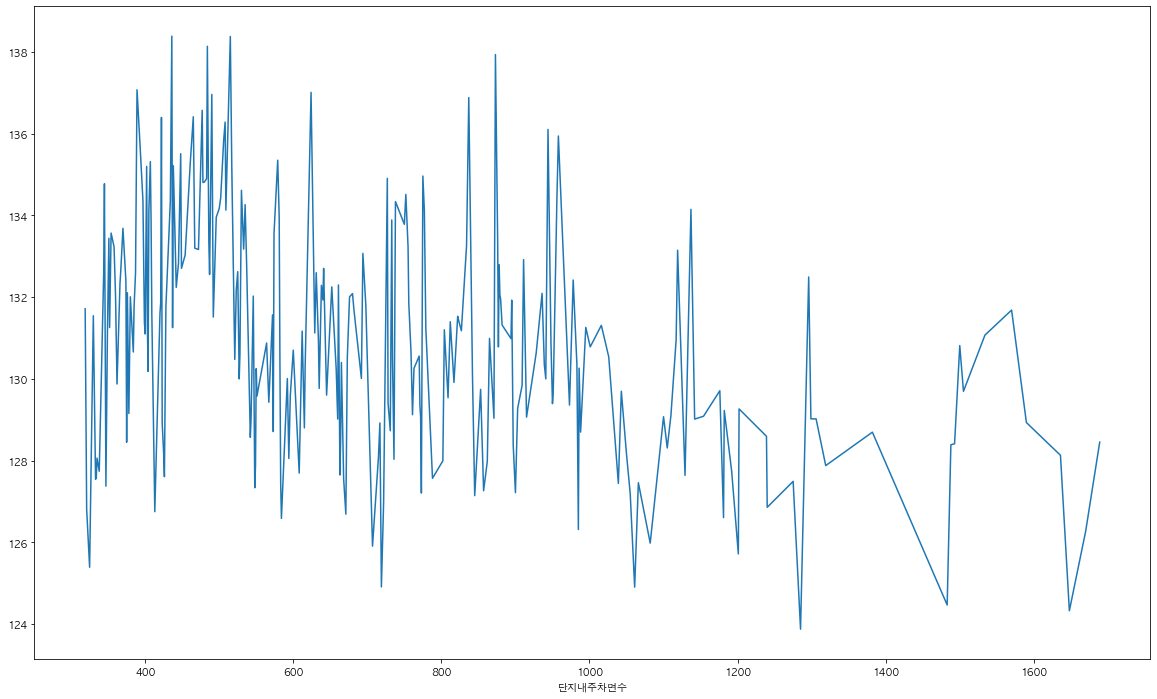

In [42]:
plt.figure(figsize=(20,12))
sns.lineplot(x = tmp[:306], y = mae_all)


In [11]:
train_one.공가수.sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 46., 47., 49., 55.])

In [13]:
# q1, q3 = list(train_one.공가수.quantile((.25,.75)))

tmp = train_one.공가수.sort_values().unique()[1:]
# tmp = train_one.공가수.unique()
mae_down = []
mae_up = []
mae_all = []
for t in tmp: 
    print("------------------------")
    print("down",t)
    train_up = train_one[train_one['공가수']>=t].reset_index(drop=True)
    train_down = train_one[train_one['공가수']<t].reset_index(drop=True)
    test_up = test_one[test_one['공가수']>=t].reset_index(drop=True)
    test_down = test_one[test_one['공가수']<t].reset_index(drop=True)
    
    X = train_down.drop(columns=['단지코드','등록차량수', "연면적new"],axis=1)
    X = pd.get_dummies(X, drop_first=True) 
    y = train_down['등록차량수']
    
    models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
    model_down,pred_down,error_down = fit_models(X, y, models, cv=True)
    print('MAE_dwn : ',error_down)
    mae_down.append(error_down)
    
    print("up",t)
    X = train_up.drop(columns=['단지코드','등록차량수', "연면적new"],axis=1)
    X = pd.get_dummies(X, drop_first=True) 
    y = train_up['등록차량수']
    
    models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
    model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
    print('MAE_up : ',error_up)
    mae_down.append(error_up)
    error = (error_down*len(train_down)+error_up*len(train_up))/(len(train_one))
    print("MAE :",error)
    mae_all.append(error)

------------------------
down 1.0
MAE_dwn :  230.36560526802637
up 1.0
MAE_up :  129.24062373829247
MAE : 133.39309882526223
------------------------
down 2.0
MAE_dwn :  206.20920641437027
up 2.0
MAE_up :  131.2124320591135
MAE : 137.73389069870103
------------------------
down 3.0
MAE_dwn :  169.62745820956027
up 3.0
MAE_up :  130.63974984391277
MAE : 136.5726619865113
------------------------
down 4.0
MAE_dwn :  157.81069960897528
up 4.0
MAE_up :  134.95948702001812
MAE : 139.4303764395967
------------------------
down 5.0
MAE_dwn :  142.9793548856631
up 5.0
MAE_up :  133.0314288792725
MAE : 135.43430955714464
------------------------
down 6.0
MAE_dwn :  140.6102287122614
up 6.0
MAE_up :  145.05521514951408
MAE : 143.90639015244636
------------------------
down 7.0
MAE_dwn :  137.84261604173042
up 7.0
MAE_up :  137.21863021862833
MAE : 137.39195961393446
------------------------
down 8.0
MAE_dwn :  123.1059208504493
up 8.0
MAE_up :  141.61127548533176
MAE : 134.99583469798247
-------

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.

In [15]:
np.min(mae_all), np.argmin(mae_all)

(128.5825837849204, 38)

In [22]:
tmp[1:len(mae_all)+1][38]

40.0

<AxesSubplot:>

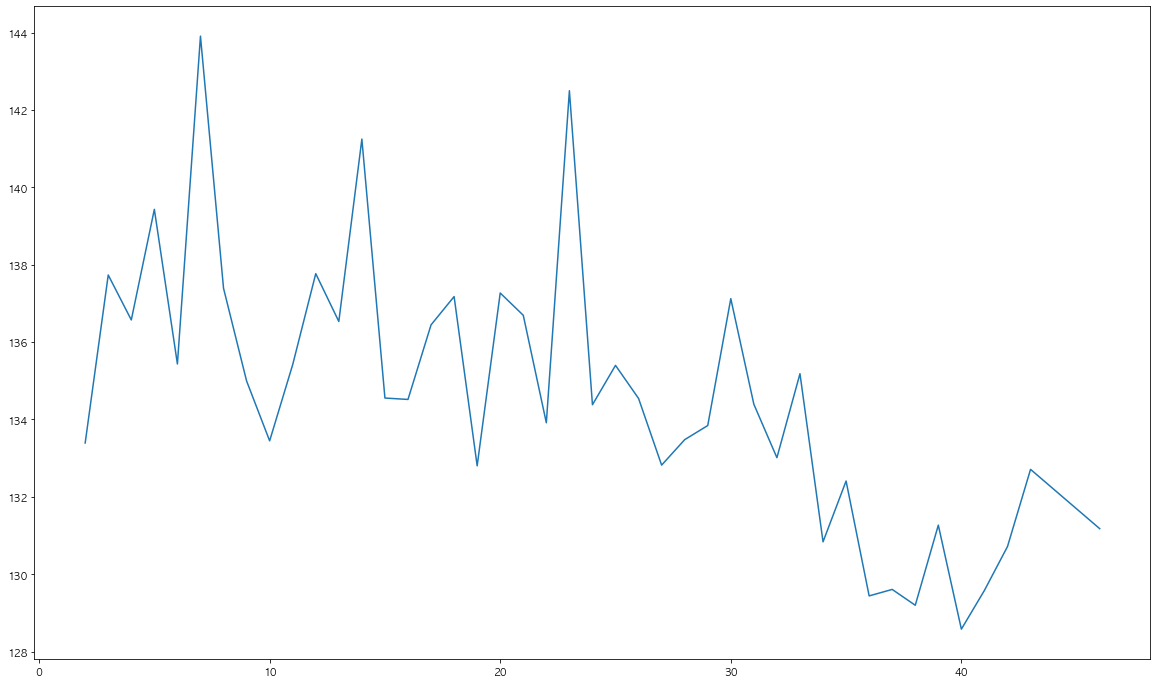

In [23]:
plt.figure(figsize=(20,12))
sns.lineplot(x = tmp[1:len(mae_all)+1], y = mae_all)


In [29]:
train_one.지역.value_counts()

경기도        85
경상남도       54
강원도        37
충청북도       30
대전광역시      25
부산광역시      25
전라남도       24
광주광역시      24
전라북도       21
경상북도       21
충청남도       19
대구광역시      18
제주특별자치도    14
울산광역시       7
서울특별시       7
세종특별자치시     3
Name: 지역, dtype: int64

## 경기도

In [32]:
train1 = train_one[train_one.지역.isin(["경기도","서울특별시"])]
len(train1)

92

In [33]:
X = train1.drop(columns=['단지코드','등록차량수', "연면적new"],axis=1)
X = pd.get_dummies(X, drop_first=True) 
y = train1['등록차량수']
    
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model1,pred1,error1 = fit_models(X, y, models, cv=True)
print('MAE_dwn : ',error1)


MAE_dwn :  164.56657787942967


In [34]:
train2 = train_one[train_one.지역.isin(["부산광역시","세종특별자치시"])]
len(train2)

28

In [35]:
X = train2.drop(columns=['단지코드','등록차량수', "연면적new"],axis=1)
X = pd.get_dummies(X, drop_first=True) 
y = train2['등록차량수']
    
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model2,pred2,error2 = fit_models(X, y, models, cv=True)
print('MAE_dwn : ',error2)


MAE_dwn :  216.90850908997692


In [57]:
train_one.지역.unique()

array(['경상남도', '대전광역시', '경기도', '전라북도', '강원도', '광주광역시', '충청남도', '부산광역시',
       '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '대구광역시', '서울특별시',
       '세종특별자치시'], dtype=object)

In [59]:
district = ["부산광역시","세종특별자치시","대전광역시","서울특별시","경기도","경상남도","경상북도","충청남도","울산광역시"]

In [60]:
train2 = train_one[train_one.지역.isin(district)]
len1 = len(train2)
len1

246

In [61]:
X = train2.drop(columns=['단지코드','등록차량수', "연면적new"],axis=1)
X = pd.get_dummies(X, drop_first=True) 
y = train2['등록차량수']
    
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model2,pred2,error2 = fit_models(X, y, models, cv=True)
print('MAE_dwn : ',error2)


MAE_dwn :  150.79700231332612


In [62]:
train3 = train_one[-train_one.지역.isin(district)]
len2 = len(train3)
len2

168

In [63]:
X = train3.drop(columns=['단지코드','등록차량수', "연면적new"],axis=1)
X = pd.get_dummies(X, drop_first=True) 
y = train3['등록차량수']
    
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model3,pred3,error3 = fit_models(X, y, models, cv=True)
print('MAE_dwn : ',error3)


MAE_dwn :  127.46732214497654


In [64]:
(error2*len1+error3*len2)/(len1+len2)

141.32988572327122

In [ ]:
train_one["label"] = 

In [37]:
X = train2.drop(columns=['단지코드','등록차량수', "연면적new"],axis=1)
X = pd.get_dummies(X, drop_first=True) 
y = train2['등록차량수']
    
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model2,pred2,error2 = fit_models(X, y, models, cv=True)
print('MAE_dwn : ',error2)


MAE_dwn :  153.99791004805354


In [ ]:
train2 = train_one[train_one.지역.isin(["부산광역시","세종특별자치시","대전광역시","서울특별시","경기도","대구광역시","광주광역시","울산광역시"])]
len(train2)

X = train2.drop(columns=['단지코드','등록차량수', "연면적new"],axis=1)
X = pd.get_dummies(X, drop_first=True) 
y = train2['등록차량수']
    
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model2,pred2,error2 = fit_models(X, y, models, cv=True)
print('MAE_dwn : ',error2)


### 2) train/test up

In [18]:
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율', "연면적"],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금' , '대형전용면적', 'area_0', 'area_1', 'area_2', ]]
y = train_up['등록차량수']

In [19]:
models = [
         CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
        
         ]
model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

MAE :  291.87954235273975


- 공가수/단지내주차면수

- 공가수/등록차량수

- 공가수/위도

- 공가수/경도
- 
- 공가수/subway_dist

- 세대당인구/subway_dist

- 공가수/총인구수

- 공가수/세대당인구

- 공가수/남여비율

- 공가수/남-여20-29세



In [73]:
X["단지*공가"] =X["단지내주차면수"]*X["공가수"]
X["남여2039*공가"] =X["남/여_20~39세"]*X["공가수"]
X["남여비율*공가"] =X["남/여비율"]*X["공가수"]
X["총인구수*공가"] =X["총인구수"]*X["공가수"]
X["세대당인구*공가"] =X["세대당_인구"]*X["공가수"]
X["subway_dist*공가"] =X["subway_dist"]*X["공가수"]
X["세대당인구*subway_dist"] =X["subway_dist"]*X["세대당_인구"]

In [74]:
X["단지/공가"] =X["단지내주차면수"]/X["공가수"]
X["남여2039/공가"] =X["남/여_20~39세"]/X["공가수"]
X["남여비율/공가"] =X["남/여비율"]/X["공가수"]
X["총인구수/공가"] =X["총인구수"]/X["공가수"]
X["세대당인구/공가"] =X["세대당_인구"]/X["공가수"]
X["subway_dist/공가"] =X["subway_dist"]/X["공가수"]
X["세대당인구/subway_dist"] =X["subway_dist"]/X["세대당_인구"]

In [75]:
X0 = X[['총세대수', '공가수', '지하철역', '버스정류장', "단지내주차면수", '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
    "남/여_20~39세", '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금' , '대형전용면적', 'area_0', 'area_1', 'area_2',"단지*공가"]]
y = train_up['등록차량수']

In [76]:
models = [
         CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
        
         ]
model_up,pred_up,error_up = fit_models(X0, y, models, cv=True)
print('MAE : ',error_up)

MAE :  297.3752094129575


In [79]:
X0 = X[['총세대수', '공가수', '지하철역', '버스정류장', "단지내주차면수", '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
    "남/여_20~39세", '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금' , '대형전용면적', 'area_0', 'area_1', 'area_2',"단지/공가","단지*공가"]]
y = train_up['등록차량수']

In [80]:
models = [
         CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
        
         ]
model_up,pred_up,error_up = fit_models(X0, y, models, cv=True)
print('MAE : ',error_up)

MAE :  285.1889871220469


In [83]:
X0 = X[['총세대수', '공가수',  '버스정류장', "단지내주차면수", '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
    "남/여_20~39세", '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금' , '대형전용면적', 'area_0', 'area_1', 'area_2',"총인구수*공가"]]
y = train_up['등록차량수']

In [84]:
models = [
         CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
        
         ]
model_up,pred_up,error_up = fit_models(X0, y, models, cv=True)
print('MAE : ',error_up)

MAE :  281.6286884162005


In [87]:
X0 = X[['총세대수', '공가수',  '버스정류장', "단지내주차면수", '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
    "남/여_20~39세", '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금' , '대형전용면적', 'area_0', 'area_1', 'area_2',"세대당인구*subway_dist"]]
y = train_up['등록차량수']

In [88]:
models = [
         CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
        
         ]
model_up,pred_up,error_up = fit_models(X0, y, models, cv=True)
print('MAE : ',error_up)

MAE :  290.7144466797361


In [66]:
X0 = X[['총세대수', '공가수',  '버스정류장', "단지내주차면수", '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
 '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금' , '대형전용면적', 'area_0', 'area_1', 'area_2',"단지/공가","남여2039/공가"]]
y = train_up['등록차량수']

In [67]:
models = [
         CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
        
         ]
model_up,pred_up,error_up = fit_models(X0, y, models, cv=True)
print('MAE : ',error_up)

MAE :  297.49040122191604


In [36]:
X0 = X[['총세대수', '공가수', '지하철역', '버스정류장', "단지내주차면수", '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
    "남/여_20~39세", '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금' , '대형전용면적', 'area_0', 'area_1', 'area_2',"남여2039/공가"]]
y = train_up['등록차량수']

In [37]:
models = [
         CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
        
         ]
model_up,pred_up,error_up = fit_models(X0, y, models, cv=True)
print('MAE : ',error_up)

MAE :  288.66167335390753


In [38]:
X0 = X[['총세대수', '공가수', '지하철역', '버스정류장', "단지내주차면수", '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
    "남/여_20~39세", '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금' , '대형전용면적', 'area_0', 'area_1', 'area_2',"남여비율/공가"]]
y = train_up['등록차량수']

In [39]:
models = [
         CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
        
         ]
model_up,pred_up,error_up = fit_models(X0, y, models, cv=True)
print('MAE : ',error_up)

MAE :  291.15518413774737


In [54]:
X0 = X[['총세대수', '공가수', '지하철역', '버스정류장', "단지내주차면수", '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
    "남/여_20~39세", '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금' , '대형전용면적', 'area_0', 'area_1', 'area_2',"총인구수/공가"]]
y = train_up['등록차량수']

In [55]:
models = [
         CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
        
         ]
model_up,pred_up,error_up = fit_models(X0, y, models, cv=True)
print('MAE : ',error_up)


MAE :  281.2557053113245


In [ ]:
X0 = X[['총세대수', '공가수', '지하철역', '버스정류장', "단지내주차면수", '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
    "남/여_20~39세", '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금' , '대형전용면적', 'area_0', 'area_1', 'area_2',"총인구수/공가"]]
y = train_up['등록차량수']

In [50]:
X0 = X[['총세대수', '공가수', '지하철역', '버스정류장', "단지내주차면수", '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
    "남/여_20~39세", '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금' , '대형전용면적', 'area_0', 'area_1', 'area_2',"세대당인구/공가"]]
y = train_up['등록차량수']

In [51]:
models = [
         CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
        
         ]
model_up,pred_up,error_up = fit_models(X0, y, models, cv=True)
print('MAE : ',error_up)


MAE :  298.636074571094


In [60]:
X0 = X[['총세대수', '공가수',  '버스정류장', "단지내주차면수", '연면적new','위도', '경도',
      '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
    "남/여_20~39세", '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금' , '대형전용면적', 'area_0', 'area_1', 'area_2',"subway_dist/공가"]]
y = train_up['등록차량수']

In [61]:
models = [
         CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
        
         ]
model_up,pred_up,error_up = fit_models(X0, y, models, cv=True)
print('MAE : ',error_up)


MAE :  279.4783669509222


In [71]:
X0 = X[['총세대수', '공가수',  '버스정류장', "단지내주차면수", '연면적new','위도', '경도',
      '환승역 수', '총인구수', "세대당_인구", '남/여비율', '남/여_0~19세',
    "남/여_20~39세", '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금' , '대형전용면적', 'area_0', 'area_1', 'area_2',"세대당인구/subway_dist"]]
y = train_up['등록차량수']

In [72]:
models = [
         CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
        
         ]
model_up,pred_up,error_up = fit_models(X0, y, models, cv=True)
print('MAE : ',error_up)


MAE :  306.4730282957438


In [40]:
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

MAE :  291.87954235273975
